In [1]:
import pandas as pd
import ast
import networkx as nx
import os
import json
import matplotlib.pyplot as plt
import gender_guesser.detector as gg
import country_converter as coco
# go one up
os.chdir("..")
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

In [2]:
main_color = "#5b3d91"
vos_meta = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_meta.csv')
vos_meta.head()

,VOS_ID,Authors,Title,Year,Citations,Source,Cluster,Links,Total link strength,Norm. citations
0,2,['Nick Bostrom'],Existential Risk Prevention As Global Priority,2013,387.0,Global policy,3,303.0,33.0,11.8575
1,3,['Nick Bostrom'],Existential Risks: Analyzing Human Extinction ...,2002,176.0,[no source],3,61.0,24.0,3.7625
2,4,"['Shahar Avin', ' Bonnie C. Wintle', ' Julius ...",Classifying Global Catastrophic Risks,2018,68.0,Futures,3,226.0,13.0,4.6723
3,7,"['Simon Beard', ' Lauren Holt', ' Asaf Tzachor...",Assessing Climate Change’S Contribution To Glo...,2021,41.0,Futures,3,287.0,56.0,5.3588
4,8,"['Alexey Turchin', ' David Denkenberger']",Classification Of Global Catastrophic Risks Co...,2018,53.0,Ai & society,1,208.0,22.0,3.6416


In [3]:
# Remove the unrelated clusters
num_papers_before = vos_meta.shape[0]
other_topic_clusters = [6, 7, 8, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23]
vos_meta = vos_meta[~vos_meta["Cluster"].isin(other_topic_clusters)]
num_papers_after = vos_meta.shape[0]
print(f"Removed {num_papers_before - num_papers_after} papers from unrelated clusters")

Removed 454 papers from unrelated clusters


In [4]:
# Create a dictionary of clusters numbers and their names
cluster_names = {1: "Artificial Intelligence", 2: "Climate Change", 3: "Foundations", 4: "Risk Policy", 5: "Pandemics", 9: "Transhumanism", 10: "Reasoning and Risk", 11: "Global Resilience and Food Security", 12: "Risk management and mitigation", 17: "Bioengineering"}

In [5]:
years = vos_meta[vos_meta["Year"] < 2024].groupby("Year").size()
# Add 2003, 2005 and 2009 to the years with 0 events
years = years.reindex(range(1970, 2024)).fillna(0)

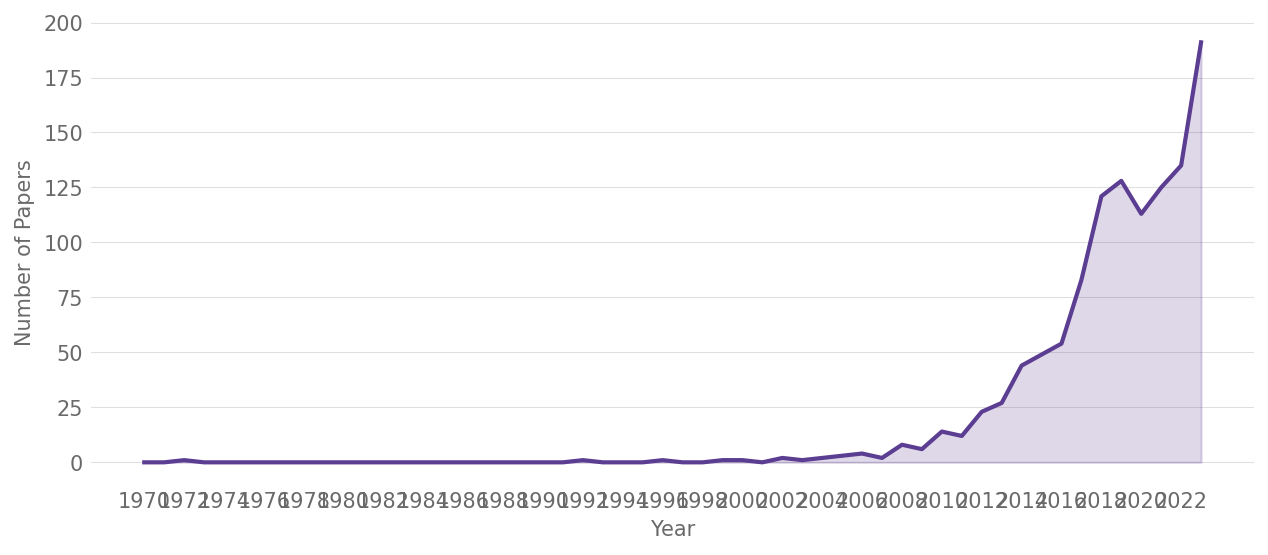

In [6]:
years.plot(kind="line", color=main_color)
# add a fill between the line and the x axis
plt.fill_between(years.index, years, color=main_color, alpha=0.2)
# Remove x grid
plt.gca().xaxis.grid(False)
plt.ylabel("Number of Papers")
# Show every 2nd year
plt.xticks(years.index[::2]);

In [7]:
cluster_years = vos_meta[vos_meta["Year"] < 2024].groupby(["Year", "Cluster"]).size().unstack().fillna(0)

In [8]:
# Only plot the years after 2000 (inclusive)
cluster_years = cluster_years.loc[2000:]

In [9]:
cluster_years.columns = ["Artificial\nIntelligence", "Climate Change", "Foundations", "Risk Policy", "Pandemics", "Transhumanism", "Reasoning\nand Risk", "Global Resilience\nand Food Security", "Risk management\nand mitigation", "Bioengineering"]

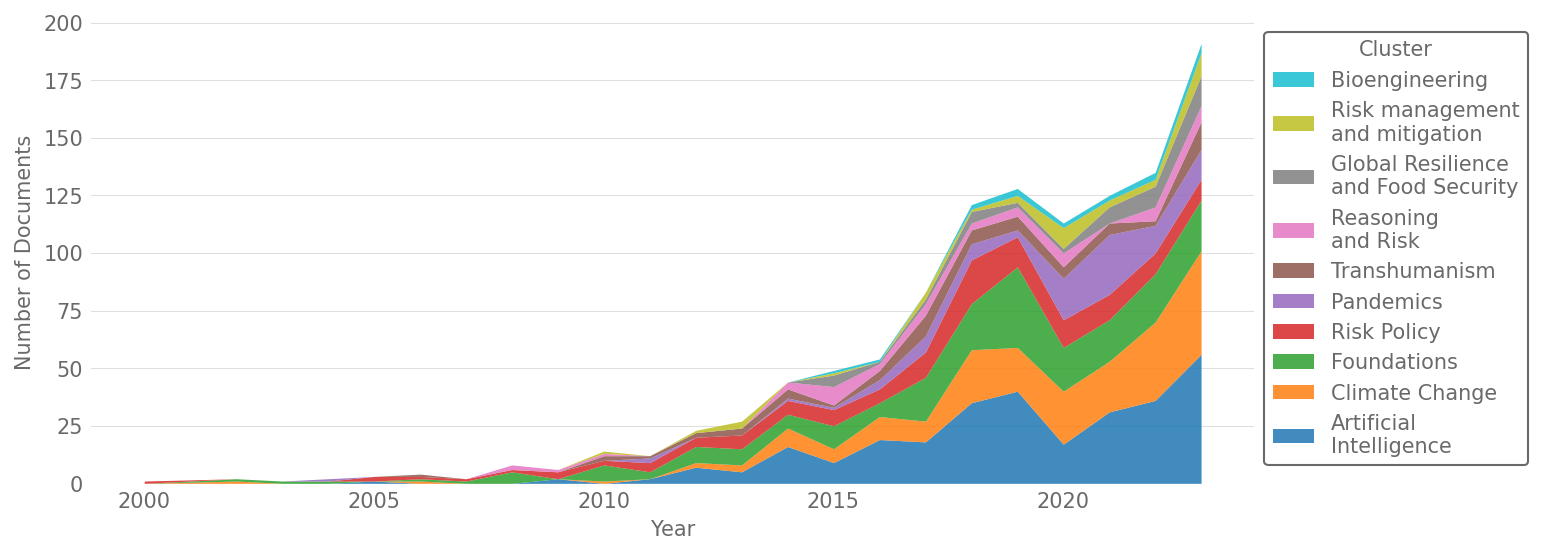

In [10]:
# Plot the area chart
ax = cluster_years.plot(kind="area", colormap="tab10", linewidth=0, alpha = 0.85)

# Get the handles and labels from the current legend
handles, labels = ax.get_legend_handles_labels()

# Reverse the order of both handles and labels
ax.legend(handles[::-1], labels[::-1], title="Cluster", bbox_to_anchor=(1, 1))

# Set y-axis label
plt.ylabel("Number of Documents")

# Remove gridlines from the x-axis
plt.gca().xaxis.grid(False)

fig = plt.gcf()
fig.set_size_inches(10, 4)

# Show the plot
plt.show()


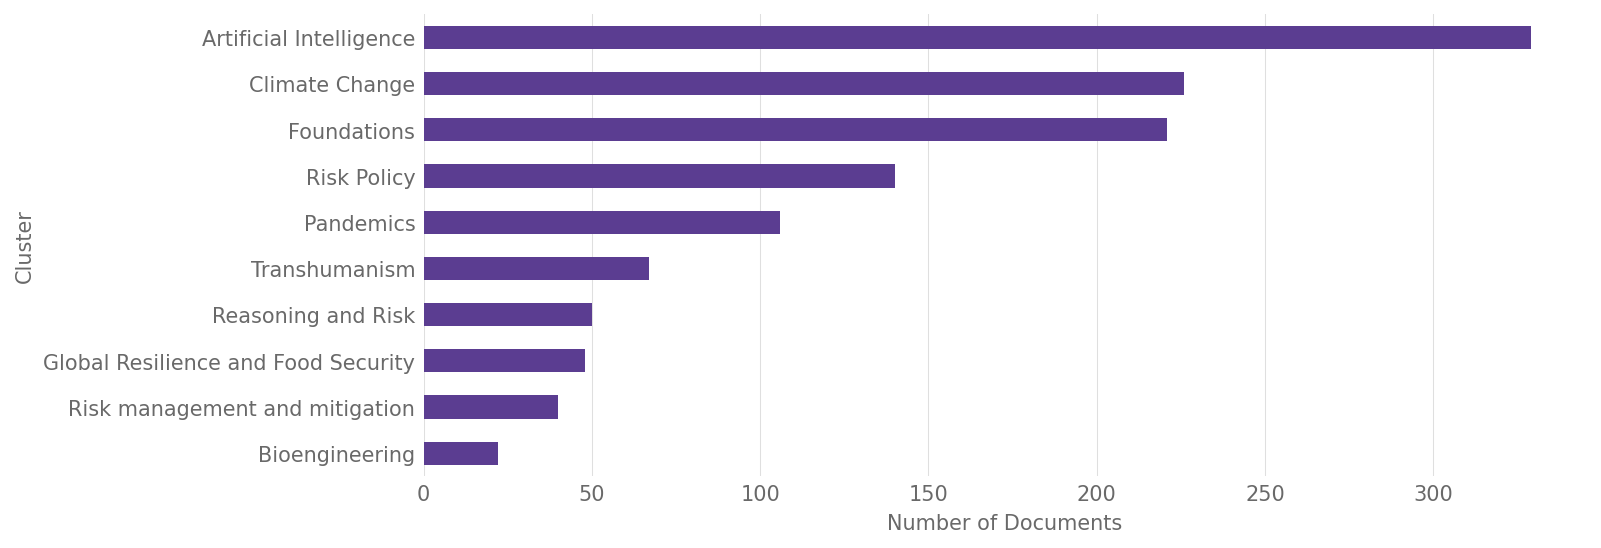

In [11]:
# Create a barplot that shows the number of papers per cluster
cluster_counts = vos_meta["Cluster"].value_counts().sort_index(ascending=False)
cluster_counts.index = cluster_counts.index.map(cluster_names)
cluster_counts.plot(kind="barh", color=main_color)
plt.xlabel("Number of Documents")
plt.ylabel("Cluster")
plt.gca().yaxis.grid(False)

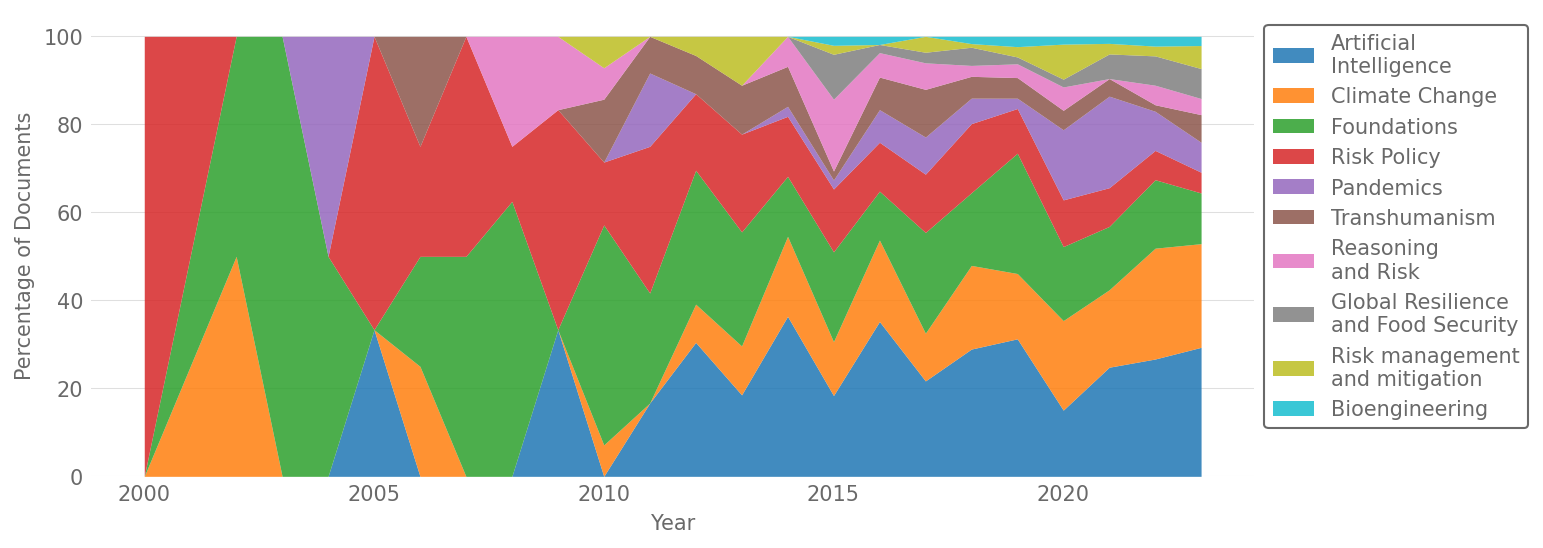

In [12]:
# And now the same plot but with the percentage of papers in each cluster
# Only do this from 2010 onwards
cluster_years_percentage = cluster_years.loc[2000:].div(cluster_years.loc[2000:].sum(axis=1), axis=0) * 100
cluster_years_percentage.plot(kind="area", colormap="tab10", linewidth=0, alpha = 0.85)
plt.gca().legend().set_title("Cluster")
plt.gca().legend().set_bbox_to_anchor((1, 1))
plt.ylabel("Percentage of Documents")
plt.gca().xaxis.grid(False)

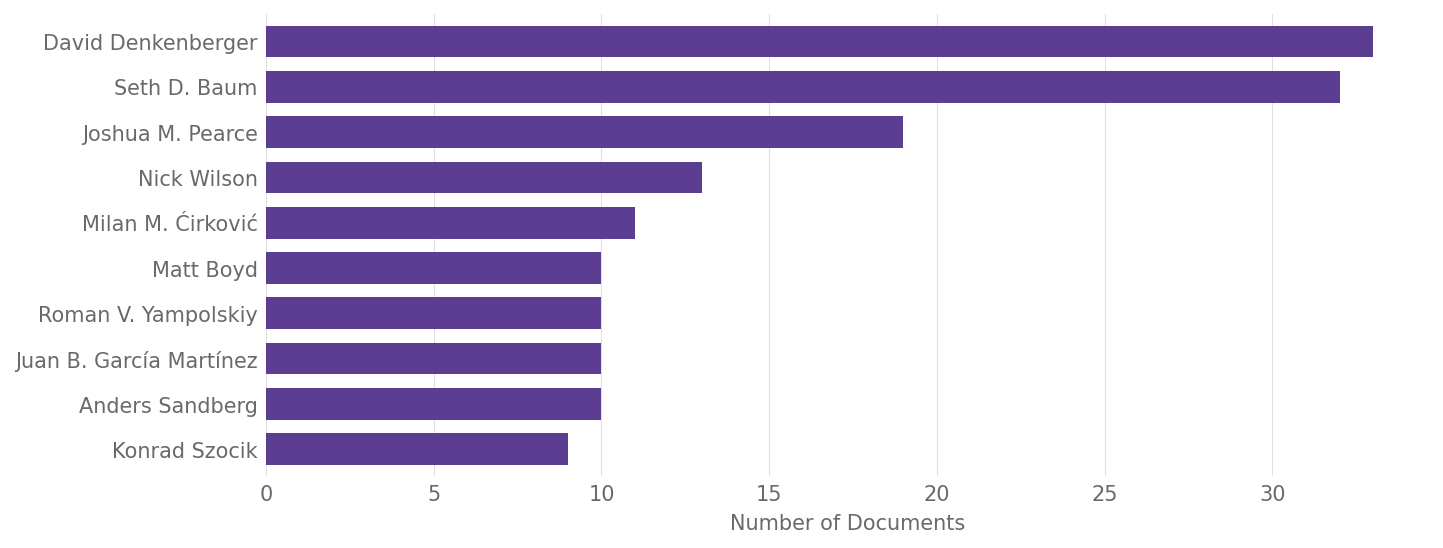

In [13]:
authors = vos_meta["Authors"].apply(ast.literal_eval)
# Create a list of all the authors
all_authors = [author for authors_list in authors for author in authors_list]
# Remove the trailing whitespace from the authors
all_authors = [author.strip() for author in all_authors]
all_authors = [author for author in all_authors if author != ""]
# Count how often each author appears
author_counts = pd.Series(all_authors).value_counts()
author_counts.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)
# Remove the x-axis grid
plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")
plt.savefig(f"results{os.sep}top_authors.png", bbox_inches="tight", dpi=300)
plt.show()


In [14]:
gender_detector = gg.Detector()
# Go through all the authors and get their gender
gender_counts_all = {"male": 0, "female": 0, "unknown": 0, "mostly_male": 0, "mostly_female": 0, "andy": 0}
for author in set(all_authors):
    # Only use the first name
    first_name = author.split(" ")[0]
    # Get the gender
    gender = gender_detector.get_gender(first_name)
    gender_counts_all[gender] += 1

counter = {"male": 0, "female": 0, "unknown": 0, "mostly_male": 0, "mostly_female": 0, "andy": 0}
gender_counts_cluster = {cluster: counter.copy() for cluster in vos_meta["Cluster"].unique()}
for cluster_name, cluster in vos_meta.groupby("Cluster"):
    num_papers = cluster.shape[0]
    authors = cluster["Authors"].apply(ast.literal_eval)
    # Create a list of all the authors
    all_authors = [author for authors_list in authors for author in authors_list]
    # Remove the trailing whitespace from the authors
    all_authors = [author.strip() for author in all_authors]
    # Go through all the authors and determine their gender
    for author in set(all_authors):
        # Only use the first name
        first_name = author.split(" ")[0]
        # Get the gender
        gender = gender_detector.get_gender(first_name)
        gender_counts_cluster[cluster_name][gender] += 1


In [15]:
gender_df_all = pd.DataFrame(gender_counts_all, index=["All Clusters"])
# Create a DataFrame
gender_df = pd.DataFrame(gender_counts_cluster).transpose()
# combine the two DataFrames
gender_df = pd.concat([gender_df_all, gender_df], axis=0)
# Replace the cluster numbers with their names
gender_df.index = gender_df.index.map(lambda x: cluster_names.get(x, x))
gender_df

,male,female,unknown,mostly_male,mostly_female,andy
All Clusters,1384,554,424,60,44,41
Foundations,235,64,47,12,5,2
Artificial Intelligence,356,102,100,13,8,21
Climate Change,337,157,112,12,10,8
Risk Policy,159,70,36,4,2,2
Global Resilience and Food Security,62,10,17,1,3,1
Reasoning and Risk,46,18,23,3,1,0
Transhumanism,49,19,12,2,0,1
Pandemics,149,88,66,9,10,5
Risk management and mitigation,55,16,13,2,2,0


In [16]:
gender_df["total_male"] = gender_df["male"] + gender_df["mostly_male"]
gender_df["total_female"] = gender_df["female"] + gender_df["mostly_female"]
gender_df["Gender Ratio"] = gender_df["total_male"] / gender_df["total_female"]
gender_df

,male,female,unknown,mostly_male,mostly_female,andy,total_male,total_female,Gender Ratio
All Clusters,1384,554,424,60,44,41,1444,598,2.414716
Foundations,235,64,47,12,5,2,247,69,3.579710
Artificial Intelligence,356,102,100,13,8,21,369,110,3.354545
Climate Change,337,157,112,12,10,8,349,167,2.089820
Risk Policy,159,70,36,4,2,2,163,72,2.263889
Global Resilience and Food Security,62,10,17,1,3,1,63,13,4.846154
Reasoning and Risk,46,18,23,3,1,0,49,19,2.578947
Transhumanism,49,19,12,2,0,1,51,19,2.684211
Pandemics,149,88,66,9,10,5,158,98,1.612245
Risk management and mitigation,55,16,13,2,2,0,57,18,3.166667


Text(0.5, 0, 'Gender Ratio [Male/Female]')

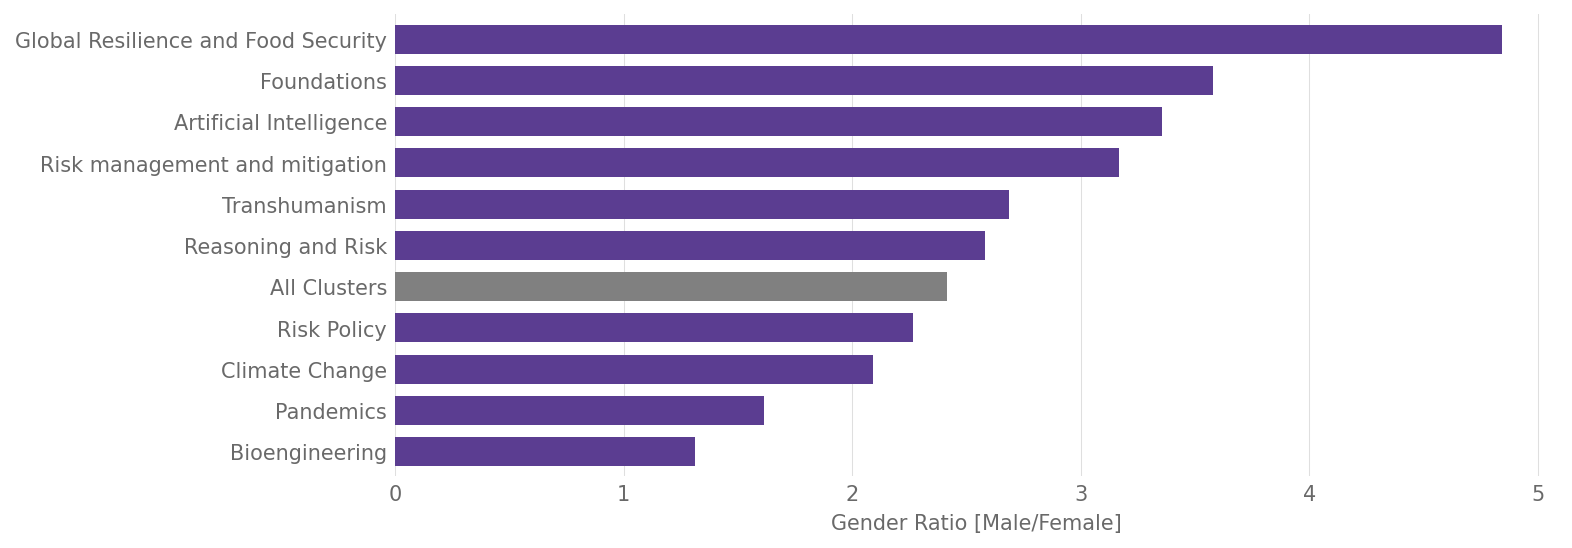

In [17]:
gender_df["Gender Ratio"].sort_values().plot(kind="barh", color=main_color, width=0.7)
# Highlight the all authors row
plt.gca().patches[4].set_facecolor("gray")
plt.gca().yaxis.grid(False)
plt.xlabel("Gender Ratio [Male/Female]")

In [18]:
remerged_data = pd.read_csv(f'data{os.sep}prepared{os.sep}remerged_data.csv')
# Remove the unrelated clusters
other_topic_clusters = [6, 7, 8, 14, 15, 16, 18, 19, 20, 21, 22, 23]

remerged_data = remerged_data[~remerged_data["Cluster"].isin(other_topic_clusters)]
remerged_data.head()

,VOS_ID,Authors,Title,Year,Citations,Source,Cluster,Links,Total link strength,Norm. citations,...,locations.source.type,locations.source,sustainable_development_goals.id,sustainable_development_goals.display_name,sustainable_development_goals.score,grants.funder,grants.funder_display_name,grants.award_id,counts_by_year.year,counts_by_year.cited_by_count
0,476,"['Nina Rosenbusch', ' Jan Brinckmann', ' Andre...",Is Innovation Always Beneficial? A Meta-Analys...,2011,1435.0,Journal of business venturing,4,96.0,34.0,23.4502,...,journal|repository,nan|nan,https://metadata.un.org/sdg/9,"Industry, innovation and infrastructure",0.63,NaN,NaN,NaN,2024|2023|2022|2021|2020|2019|2018|2017|2016|2...,40|130|144|152|159|144|127|99|121|95|99|62|38
3,365,"['Nick Bostrom', ' Eliezer Yudkowsky']",The Ethics Of Artificial Intelligence,2014,412.0,Cambridge university press ebooks,1,270.0,9.0,20.7529,...,ebook platform|repository,nan|nan,https://metadata.un.org/sdg/16,"Peace, justice, and strong institutions",0.48,NaN,NaN,NaN,2024|2023|2022|2021|2020|2019|2018|2017|2016|2...,24|48|63|81|77|59|22|14|7|1|3|1
5,2,['Nick Bostrom'],Existential Risk Prevention As Global Priority,2013,387.0,Global policy,3,303.0,33.0,11.8575,...,journal,NaN,https://metadata.un.org/sdg/12|https://metadat...,Responsible consumption and production|Life on...,0.43|0.42,NaN,NaN,NaN,2024|2023|2022|2021|2020|2019|2018|2017|2016|2...,67|38|41|50|47|34|30|20|20|16|14|4
6,526,"['Theodore G. Shepherd', ' Emily Boyd', ' Raph...",Storylines: An Alternative Approach To Represe...,2018,347.0,Climatic change,3,29.0,12.0,23.8425,...,journal|repository|repository|repository|repos...,nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|na...,https://metadata.un.org/sdg/13,Climate action,0.81,https://openalex.org/F4320320006|https://opena...,Royal Society|H2020 European Research Council,IS150011|339390,2024|2023|2022|2021|2020|2019|2018,50|108|66|73|42|11|1
7,605,['Ole Wæver'],European Security Identities,1996,315.0,Journal of common market studies,5,10.0,8.0,3.5795,...,journal,NaN,https://metadata.un.org/sdg/10,Reduced inequalities,0.51,NaN,NaN,NaN,2024|2023|2022|2021|2020|2019|2018|2017|2016|2...,18|20|9|9|13|8|11|9|15|8|15|12|12


Text(0.5, 0, 'Number of Documents')

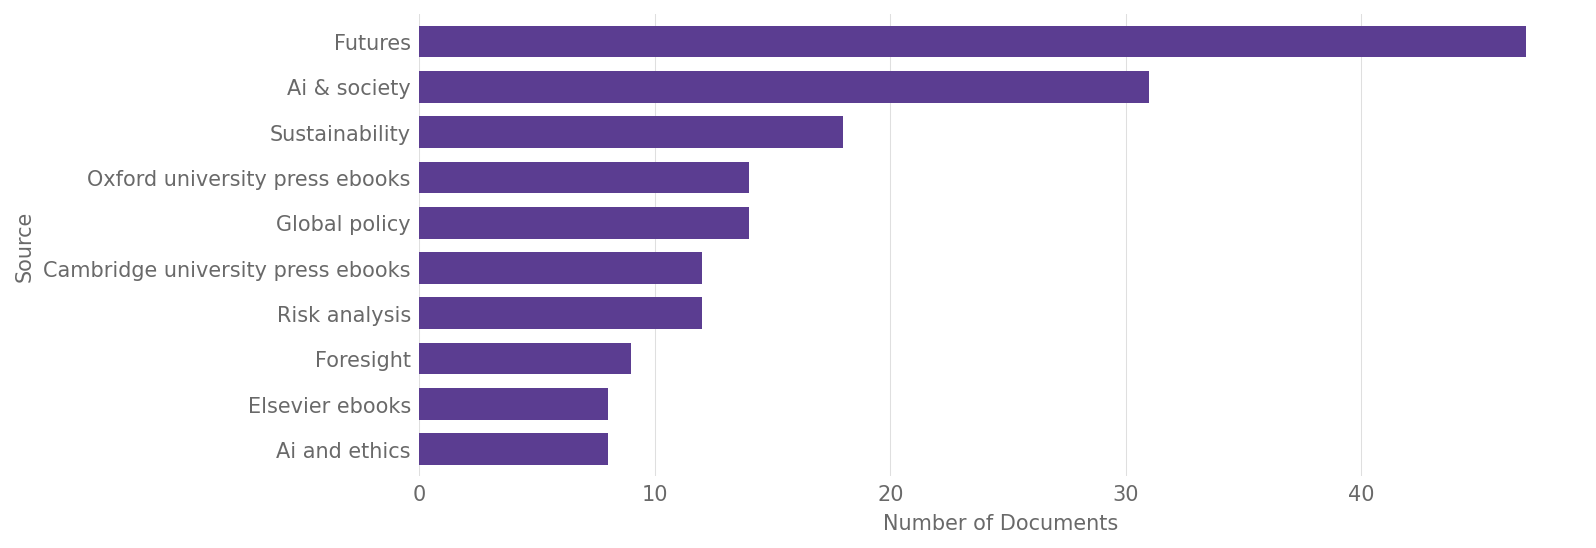

In [19]:
# Detect the main journals for the whole dataset
journals = remerged_data["Source"].value_counts()
# Remove "[no source]" from the journals
journals = journals.drop("[no source]")
journals.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)

plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")

Text(0, 0.5, 'Country')

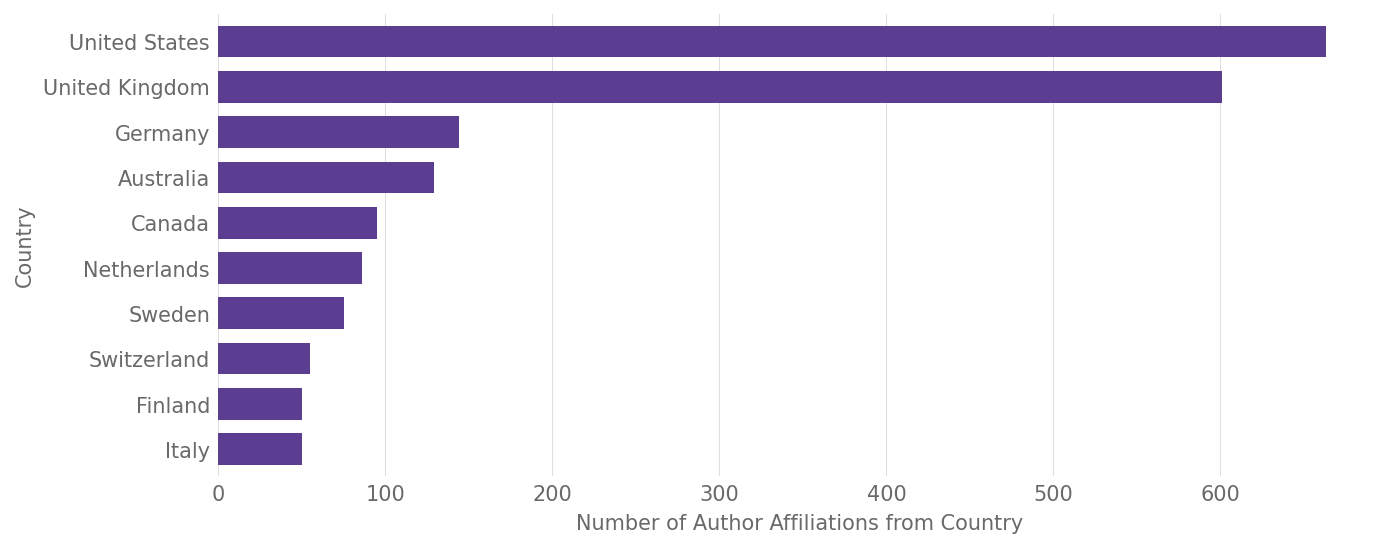

In [26]:
# Look at the main countries for the whole dataset
countries = remerged_data["authorships.countries"].str.split("|").explode().value_counts()
# Remove the empty countries
countries = countries.drop("")
# Convert the country codes to names
country_codes = countries.index
countries.index = coco.convert(names=country_codes, to="name_short")

countries.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)
plt.gca().yaxis.grid(False)
plt.xlabel("Number of Author Affiliations from Country")
plt.ylabel("Country")


In [21]:
countries

authorships.countries
US    663
GB    601
DE    144
AU    129
CA     95
     ... 
KH      1
MO      1
CR      1
ZM      1
LB      1
Name: count, Length: 82, dtype: int64

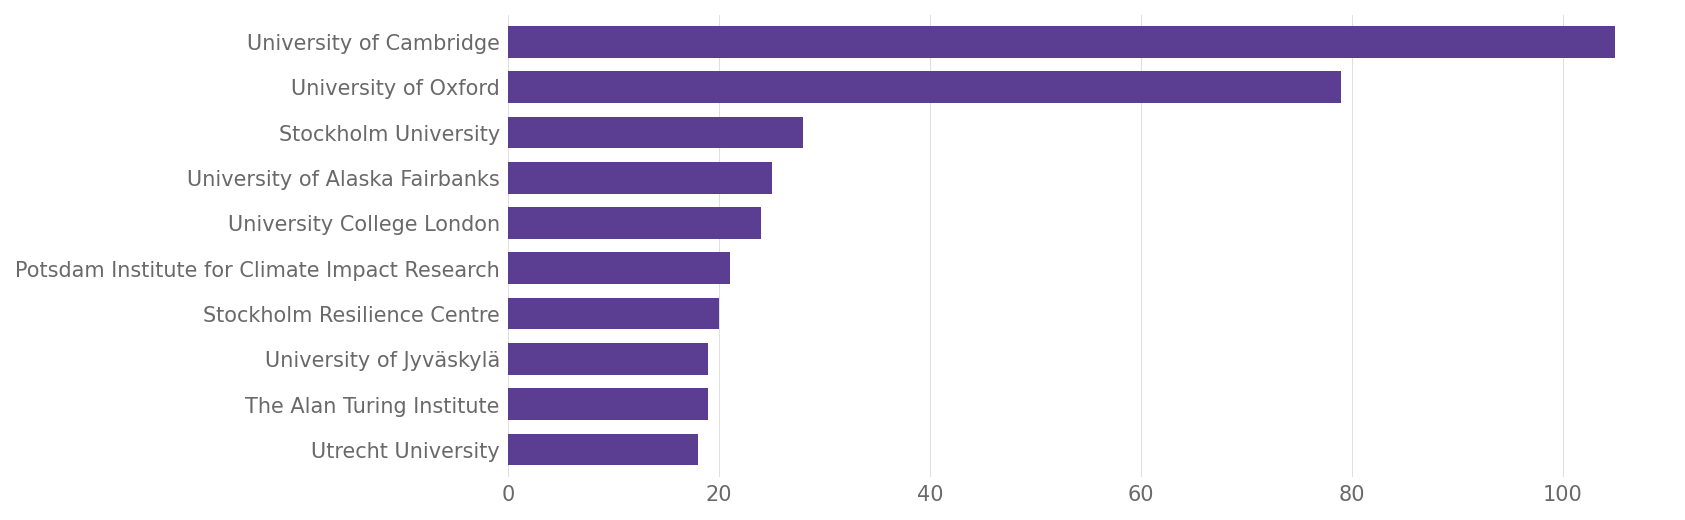

In [20]:
# Create a plot of all the organizations
# make a copy of the data
remerged_data_for_orgs = remerged_data.copy()
# Remove the rows with no organizations
remerged_data_for_orgs = remerged_data_for_orgs[remerged_data_for_orgs["authorships.institutions"].notnull()]

def extract_display_names(df, column_name):
    def parse_and_extract(dict_string):
        try:
            # Use ast.literal_eval to safely evaluate the dictionary string
            dict_obj = ast.literal_eval(dict_string)
            return dict_obj['display_name']
        except:
            return None

    # Split the column by '|' and apply the parsing function
    df['display_names'] = df[column_name].str.split('|').apply(
        lambda x: [parse_and_extract(d) for d in x if d]
    )

    return df


remerged_data_for_orgs = extract_display_names(remerged_data_for_orgs, 'authorships.institutions')

# Create a list of all the organizations
all_orgs = [org for org_list in remerged_data_for_orgs['display_names'] for org in org_list]
# Remove the empty organizations
all_orgs = [org for org in all_orgs if org != ""]
# Remove "Open Targets", "Deutsche Gesellschaft für Internationale Zusammenarbeit", "Global Environment Facility" and "Action Network"
# as they are all false positives from the same entry
all_orgs = [org for org in all_orgs if org != "Open Targets"]
all_orgs = [org for org in all_orgs if org != "Deutsche Gesellschaft für Internationale Zusammenarbeit"]
all_orgs = [org for org in all_orgs if org != "Action Network"]
all_orgs = [org for org in all_orgs if org != "Global Environment Facility"]

# Count how often each organization appears
org_counts = pd.Series(all_orgs).value_counts()
org_counts.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)
plt.gca().yaxis.grid(False)

Text(0, 0.5, 'Topic')

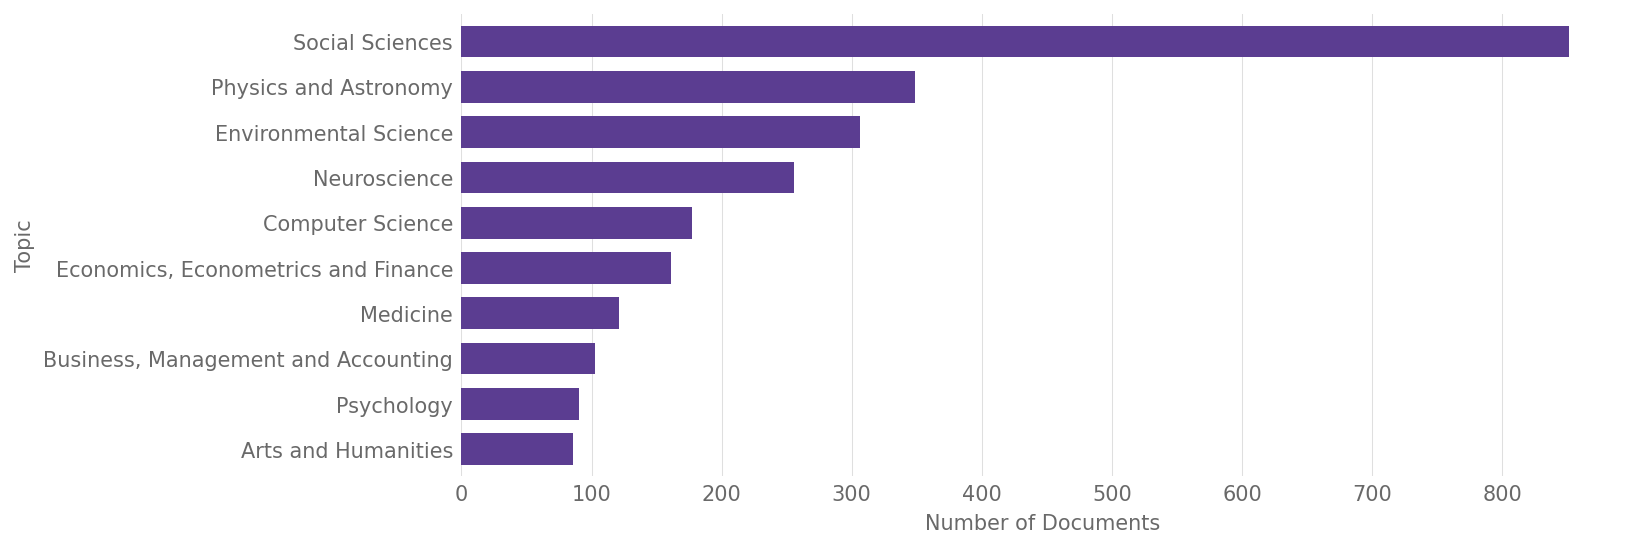

In [21]:
# Detect the main topics for the whole dataset
topics = remerged_data["topics.field.display_name"].str.split("|").explode().value_counts()

topics.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)

plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")
plt.ylabel("Topic")

Text(0, 0.5, 'Keyword')

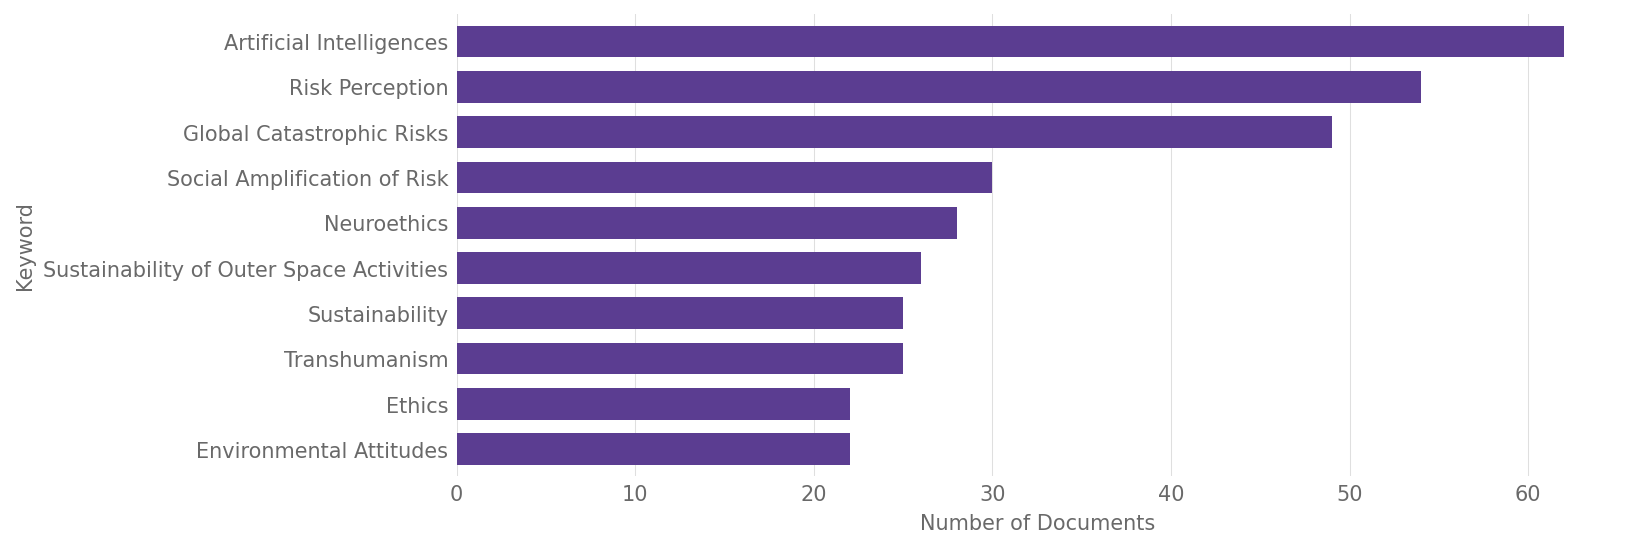

In [22]:
# Detect the main topics for the whole dataset
topics = remerged_data["keywords.display_name"].str.split("|").explode().value_counts()

topics.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)

plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")
plt.ylabel("Keyword")

Text(0, 0.5, 'Concept')

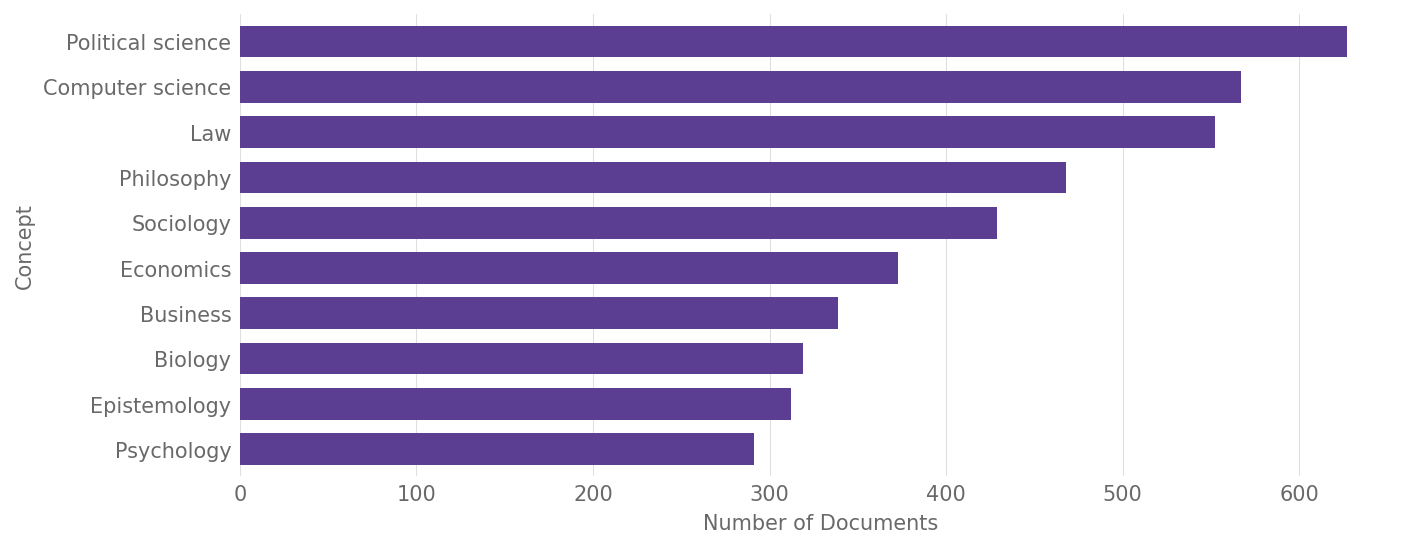

In [23]:
# Detect the main topics for the whole dataset
topics = remerged_data["concepts.display_name"].str.split("|").explode().value_counts()

topics.head(10).sort_values().plot(kind="barh", color=main_color, width=0.7)

plt.gca().yaxis.grid(False)
plt.xlabel("Number of Documents")
plt.ylabel("Concept")